In [1]:
# IMPORTAMOS LAS LIBREARIAS A USAR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [2]:
# Cargar los datos desde un archivo CSV con el delimitador "|"
df = pd.read_csv('20230630_BASE_JUNIO_CENCOSUD_TC_CET.csv', delimiter='|')
print(df.shape)


(36177, 15)


In [3]:
df

,FLG_CLIENTE_NUEVO,RECURRENCIA,QUINTIL_PROPENSION,LINEA_CENCOSUD,RNG_LINEA_CENCOSUD,NUM_TC,RNG_EDAD,REGIMEN_LABORAL,SEG_CONTACT,SEGMENTO,TIPO_TARJETA_CENCO,IDCLIENTE,CLTS,CLTS_CET,CLTS_VTA_REAL
0,0,1,1,5000,E,5,F,DEP,C2,TC1,CLASICA,7097681,1,1,0
1,0,0,1,5000,E,2,F,INDEP,C1,TC1,CLASICA,7041732,1,1,0
2,0,0,1,1400,D,1,G,DEP,C1,TC1,CLASICA,6999934,1,1,0
3,0,0,1,10000,F,1,F,INDEP,C1,TC1,CLASICA,7003244,1,1,0
4,0,1,1,10000,F,4,D,INDEP,C2,TC1,CLASICA,6801563,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36172,1,1,3,500,B,0,A,INFOR,C3,TC3,CLASICA,70911482,1,1,0
36173,1,1,5,1000,C,0,B,INDEP,C3,TC3,CLASICA,70925221,1,1,0
36174,0,0,1,4000,E,3,B,DEP,C1,TC2,CLASICA,73694890,1,1,0
36175,0,0,1,8000,F,1,B,INFOR,C1,TC2,CLASICA,72468761,1,1,0


In [4]:
# Calcular el valor mínimo y máximo de linea cencosud
min_precios = df.groupby('RNG_LINEA_CENCOSUD')['LINEA_CENCOSUD'].min()
max_precios = df.groupby('RNG_LINEA_CENCOSUD')['LINEA_CENCOSUD'].max()

# Imprimir los resultados
print("Valor mínimo de precios por rango:")
print(min_precios)
print("\nValor máximo de precios por rango:")
print(max_precios)

Valor mínimo de precios por rango:
RNG_LINEA_CENCOSUD
B      500
C      600
D     1100
E     3100
F     6100
G    10200
Name: LINEA_CENCOSUD, dtype: int64

Valor máximo de precios por rango:
RNG_LINEA_CENCOSUD
B      500
C     1000
D     3000
E     6000
F    10000
G    15000
Name: LINEA_CENCOSUD, dtype: int64


In [5]:
# Eliminar duplicados basados en una columna específica
df = df.drop_duplicates(subset=['IDCLIENTE'])


In [6]:
df['CLTS'].unique()

array([1], dtype=int64)

In [7]:
df['CLTS_CET'].unique()

array([1], dtype=int64)

In [8]:
data = df.copy()

In [9]:
# Eliminamos columnas que solo tienen una variable o datos innecesarios para el modelo de prediccion

data = data.drop('CLTS', axis=1)
data = data.drop('CLTS_CET', axis=1)
data = data.drop('IDCLIENTE', axis=1)

In [10]:
data.head()

,FLG_CLIENTE_NUEVO,RECURRENCIA,QUINTIL_PROPENSION,LINEA_CENCOSUD,RNG_LINEA_CENCOSUD,NUM_TC,RNG_EDAD,REGIMEN_LABORAL,SEG_CONTACT,SEGMENTO,TIPO_TARJETA_CENCO,CLTS_VTA_REAL
0,0,1,1,5000,E,5,F,DEP,C2,TC1,CLASICA,0
1,0,0,1,5000,E,2,F,INDEP,C1,TC1,CLASICA,0
2,0,0,1,1400,D,1,G,DEP,C1,TC1,CLASICA,0
3,0,0,1,10000,F,1,F,INDEP,C1,TC1,CLASICA,0
4,0,1,1,10000,F,4,D,INDEP,C2,TC1,CLASICA,0


In [11]:
# Observamos los tipos de variables que ahora tenemos
var_categoricas=data.select_dtypes(include=['object']).columns.to_list()
var_numericas=data.select_dtypes(include=['number']).columns.to_list()

In [12]:
var_categoricas

['RNG_LINEA_CENCOSUD',
 'RNG_EDAD',
 'REGIMEN_LABORAL',
 'SEG_CONTACT',
 'SEGMENTO',
 'TIPO_TARJETA_CENCO']

In [13]:
var_numericas

['FLG_CLIENTE_NUEVO',
 'RECURRENCIA',
 'QUINTIL_PROPENSION',
 'LINEA_CENCOSUD',
 'NUM_TC',
 'CLTS_VTA_REAL']

In [14]:
new_data= data.copy()


In [15]:
# observamos si los datos estan desbalanceados

new_data['CLTS_VTA_REAL'].value_counts()

0    35289
1      888
Name: CLTS_VTA_REAL, dtype: int64

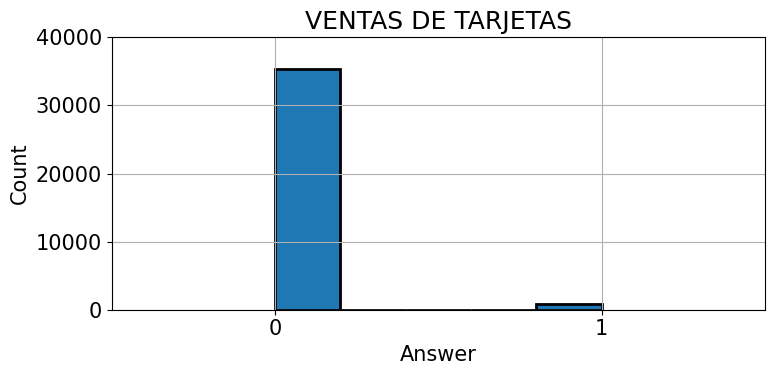

In [16]:
# Ajustar el tamaño de fuente.
plt.rcParams['font.size'] = 15 

# Crear una figura y ajusta su tamaño.
f = plt.figure(figsize=(8,4))

# Crear un subplot o subtrama - al ser una sola figura es 1,1,1.
ax = f.add_subplot(1,1,1)

# Gráfica tus datos usando 'hist'. Pasa el objeto 'ax' a Pandas. Agrega un borde negro con un groso de 2.
new_data['CLTS_VTA_REAL'].hist(ax=ax,bins=5, edgecolor='black', linewidth=2)

# Establece los límites en el eje x.
ax.set_xlim([-0.5, 1.5])

# Establece la frecuencia de tick. Tenemos 0 y 1 que corresponden a Sí y No respectivamente.
ax.set_xticks([0, 1])

# Etiquetar xtick labels.
ax.set_xticklabels(["0", "1"])

# Crea el título.
ax.set_title("VENTAS DE TARJETAS")

# Establece la etiqueta del eje X.
ax.set_xlabel("Answer")

# Establece la etiqueta del eje Y.
ax.set_ylabel("Count")

# Establece los límites superior/inferior del eje y.
ax.set_ylim([0, 40000])

# Mace que las cosas sean bonitas, no es necesario, pero se ajusta al tamaño de la figura.
f.tight_layout()

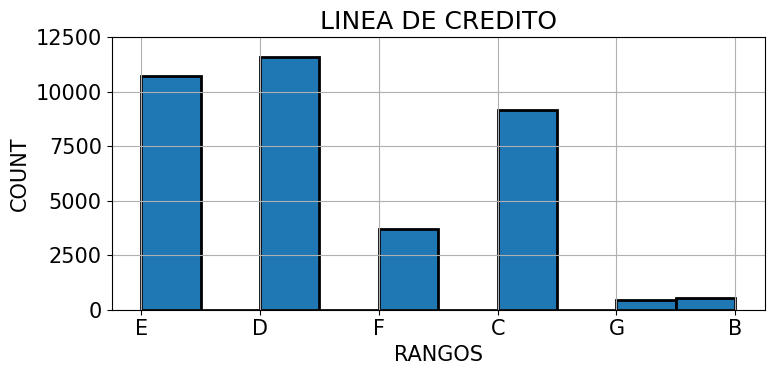

In [17]:
f = plt.figure(figsize=(8,4))
ax = f.add_subplot(1,1,1)
new_data["RNG_LINEA_CENCOSUD"].hist(ax=ax,bins=10, edgecolor='black', linewidth=2)
ax.set_title("LINEA DE CREDITO")
ax.set_ylim([0, 12500])
ax.set_xlabel("RANGOS")
ax.set_ylabel("COUNT")
f.tight_layout()

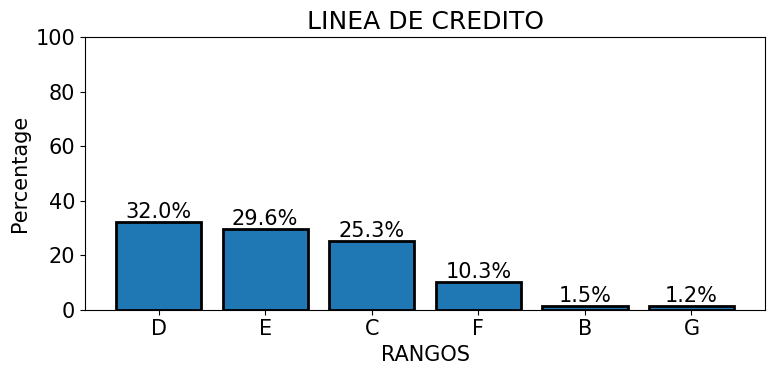

In [18]:
import matplotlib.pyplot as plt

# Calculate the value counts and percentages
value_counts = new_data["RNG_LINEA_CENCOSUD"].value_counts()
porcentajes = (value_counts / len(new_data)) * 100

# Get all unique values
valores_unicos = value_counts.index

# Create a bar plot with percentages
plt.figure(figsize=(8, 4))
plt.bar(valores_unicos, porcentajes, edgecolor='black', linewidth=2)

# Add labels to the bars
for valor, porcentaje in zip(valores_unicos, porcentajes):
    plt.annotate(f"{porcentaje:.1f}%", xy=(valor, porcentaje), ha='center', va='bottom')

plt.title("LINEA DE CREDITO")
plt.ylim([0, 100])
plt.xlabel("RANGOS")
plt.ylabel("Percentage")
plt.tight_layout()

plt.show()


In [19]:
# Lista de columnas categóricas a codificar
columnas_categoricas = ['RNG_LINEA_CENCOSUD', 'RNG_EDAD', 'REGIMEN_LABORAL', 'SEG_CONTACT', 'SEGMENTO', 'TIPO_TARJETA_CENCO']

# DataFrame con las columnas numéricas originales
df_numerico = new_data.drop(columnas_categoricas, axis=1)

# Aplicar one-hot encoding solo a las columnas categóricas
df_codificado = pd.get_dummies(new_data[columnas_categoricas], drop_first=True)
df_codificado = df_codificado.replace({True: 1, False: 0})

# Combinar el DataFrame codificado con las columnas numéricas originales
df_final = pd.concat([df_numerico, df_codificado], axis=1)

In [20]:
df_final.head()

,FLG_CLIENTE_NUEVO,RECURRENCIA,QUINTIL_PROPENSION,LINEA_CENCOSUD,NUM_TC,CLTS_VTA_REAL,RNG_LINEA_CENCOSUD_C,RNG_LINEA_CENCOSUD_D,RNG_LINEA_CENCOSUD_E,RNG_LINEA_CENCOSUD_F,...,RNG_EDAD_G,RNG_EDAD_Z,REGIMEN_LABORAL_INDEP,REGIMEN_LABORAL_INFOR,SEG_CONTACT_C2,SEG_CONTACT_C3,SEG_CONTACT_WTF,SEGMENTO_TC2,SEGMENTO_TC3,TIPO_TARJETA_CENCO_CLASICA
0,0,1,1,5000,5,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,1,5000,2,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,1,1400,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,1,10000,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0,1,1,10000,4,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1


In [21]:
# guardamos los datos de caracteristicas a excepcion de la columna a predecir
X = df_final.drop('CLTS_VTA_REAL', axis=1)

In [22]:
# guardamos los datos que queremos predecir despues del testeo
y = df_final['CLTS_VTA_REAL']

In [23]:
# importamos el train_test_split para el entrenamiento de los datos con un 80% de datos como entrenamiento y el 20% como testeo
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8)

In [24]:
# hacemos un shape para ver la cantidad de datos
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((28941, 25), (7236, 25), (28941,), (7236,))

In [25]:
st_x=RobustScaler()

X_train=st_x.fit_transform(X_train)
X_test=st_x.transform(X_test)

In [26]:
from imblearn.over_sampling import RandomOverSampler

# Crear el objeto RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Aplicar el sobremuestreo a ambos conjuntos
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [27]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [28]:
print(model_rf.score(X_test, y_test))

0.8988391376451078


In [29]:
from sklearn.linear_model import LogisticRegression

model_lg=LogisticRegression(max_iter=1000)
model_lg.fit(X_train_resampled,y_train_resampled)

LogisticRegression(max_iter=1000)

In [30]:
print(model_lg.score(X_test, y_test))

0.6948590381426202


In [31]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier()
model_xgb.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
print(model_xgb.score(X_test, y_test))

0.8237976782752903


In [33]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#FUNCION PARA GRAFICAR LA CURVAR ROC Y HALLAR GINI
def roc_gini(modelo):
    y_pred = modelo.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred)
    auc_rf = auc(fpr_rf, tpr_rf)
    gini_rf = auc(fpr_rf, tpr_rf) * 2 - 1
    f = plt.figure(1)
    f.set_figwidth(10)
    f.set_figheight(10)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='Modelo (area = {:.3f}, gini= {:.3f})'.format(auc_rf,gini_rf))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    return auc_rf

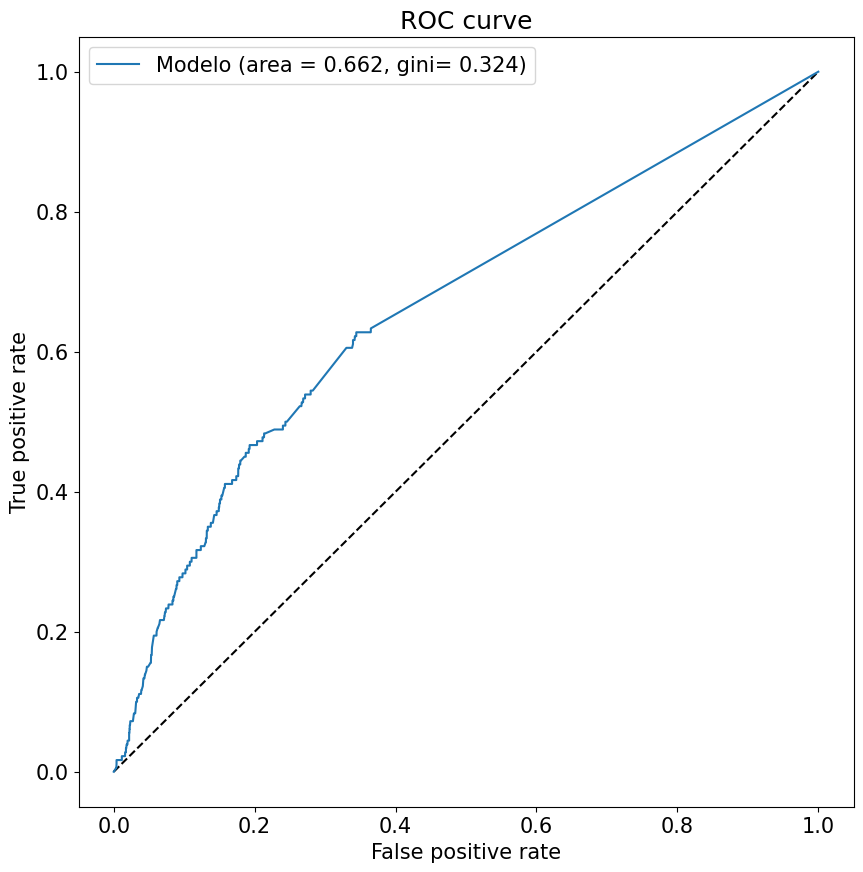

In [34]:
roc_auc=roc_gini(model_rf)

Reporte de metricas Regresion logistica: 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95      7056
           1       0.07      0.25      0.11       180

    accuracy                           0.90      7236
   macro avg       0.52      0.58      0.53      7236
weighted avg       0.96      0.90      0.93      7236

Matriz de Confusión:
 [[6459  597]
 [ 135   45]]


Text(0, 0.5, 'Valor Real')

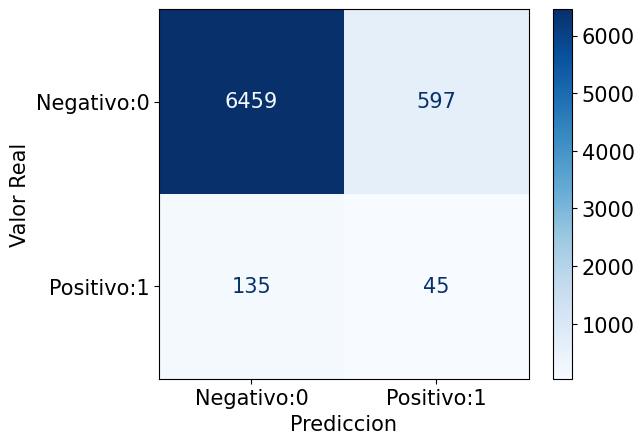

In [35]:
y_preds=model_rf.predict(X_test)
print("Reporte de metricas Regresion logistica: \n", classification_report(y_test, y_preds))
matriz = confusion_matrix(y_test, y_preds)
print('Matriz de Confusión:\n',matriz)

mc=confusion_matrix(y_test,y_preds)
cm_display =ConfusionMatrixDisplay(mc,display_labels=["Negativo:0", "Positivo:1"]).plot(cmap=plt.cm.Blues)
cm_display.ax_.set_xlabel("Prediccion")
cm_display.ax_.set_ylabel("Valor Real")

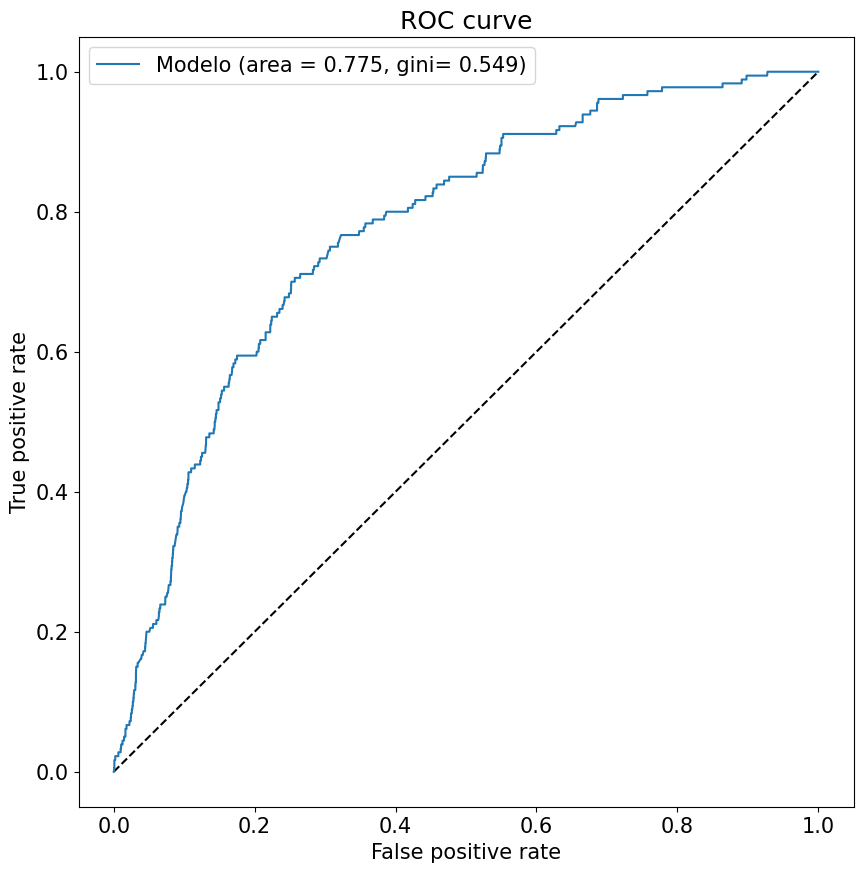

In [36]:
roc_auc=roc_gini(model_lg)

Reporte de metricas Regresion logistica: 
               precision    recall  f1-score   support

           0       0.99      0.69      0.82      7056
           1       0.06      0.74      0.11       180

    accuracy                           0.69      7236
   macro avg       0.52      0.72      0.46      7236
weighted avg       0.97      0.69      0.80      7236

Matriz de Confusión:
 [[4894 2162]
 [  46  134]]


Text(0, 0.5, 'Valor Real')

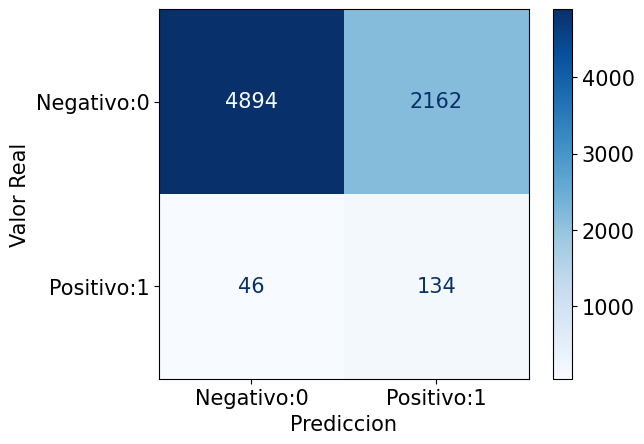

In [37]:
y_preds=model_lg.predict(X_test)
print("Reporte de metricas Regresion logistica: \n", classification_report(y_test, y_preds))
matriz = confusion_matrix(y_test, y_preds)
print('Matriz de Confusión:\n',matriz)

mc=confusion_matrix(y_test,y_preds)
cm_display =ConfusionMatrixDisplay(mc,display_labels=["Negativo:0", "Positivo:1"]).plot(cmap=plt.cm.Blues)
cm_display.ax_.set_xlabel("Prediccion")
cm_display.ax_.set_ylabel("Valor Real")

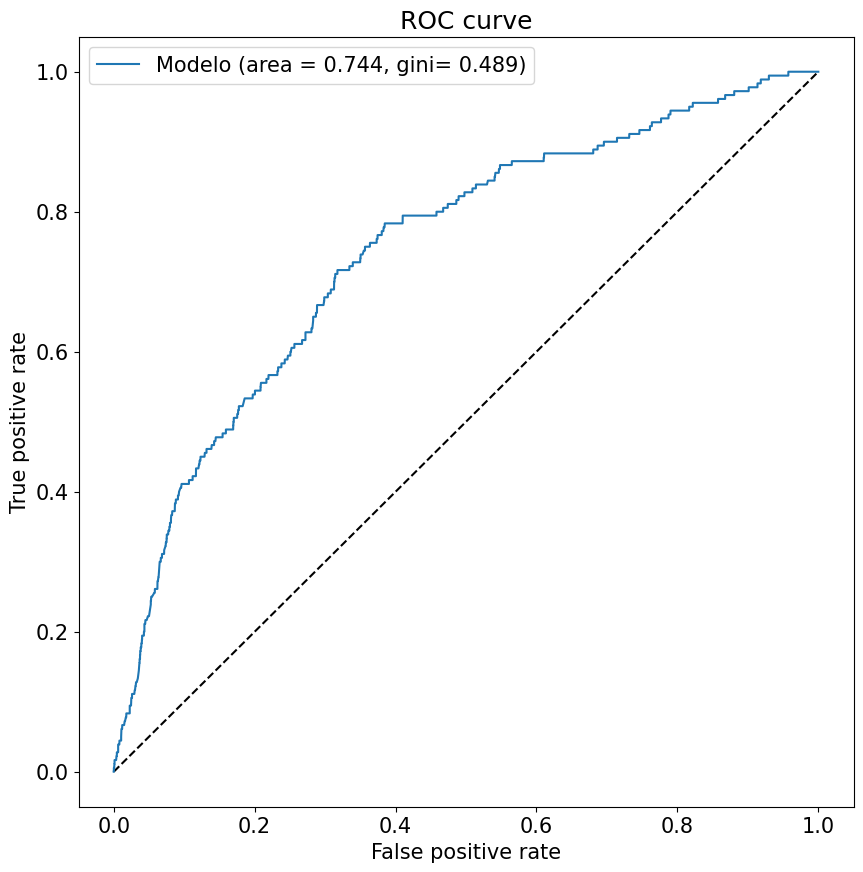

In [38]:
roc_auc=roc_gini(model_xgb)

Reporte de metricas XGBoost: 
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      7056
           1       0.07      0.49      0.12       180

    accuracy                           0.82      7236
   macro avg       0.53      0.66      0.51      7236
weighted avg       0.96      0.82      0.88      7236

Matriz de Confusión:
 [[5873 1183]
 [  92   88]]


Text(0, 0.5, 'Valor Real')

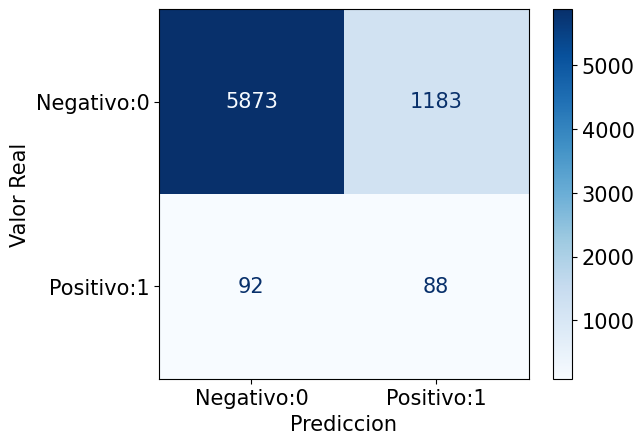

In [39]:
y_preds = model_xgb.predict(X_test)
print("Reporte de metricas XGBoost: \n", classification_report(y_test, y_preds))
matriz = confusion_matrix(y_test, y_preds)
print('Matriz de Confusión:\n',matriz)


mc=confusion_matrix(y_test,y_preds)
cm_display =ConfusionMatrixDisplay(mc,display_labels=["Negativo:0", "Positivo:1"]).plot(cmap=plt.cm.Blues)
cm_display.ax_.set_xlabel("Prediccion")
cm_display.ax_.set_ylabel("Valor Real")

In [40]:
# intentamos con otro modelo

import lightgbm as lgb

model = lgb.LGBMClassifier()
model.fit(X_train_resampled, y_train_resampled)

LGBMClassifier()

In [41]:
print(model.score(X_test, y_test))

0.7740464344941956


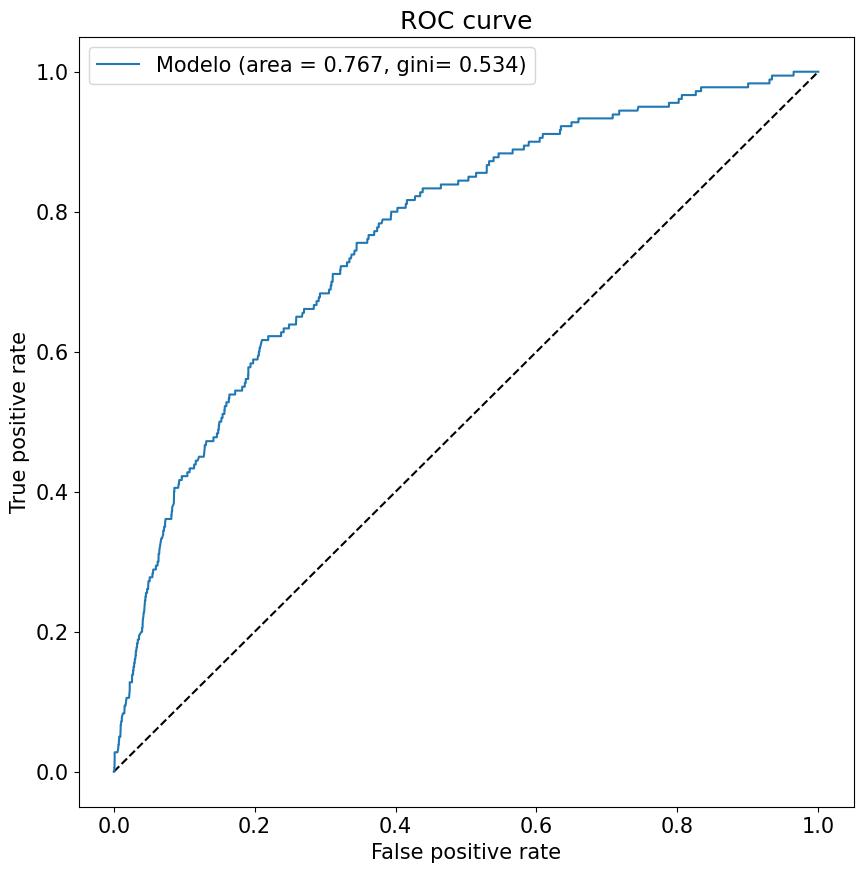

In [42]:
roc_auc=roc_gini(model)

Reporte de metricas XGBoost: 
               precision    recall  f1-score   support

           0       0.99      0.78      0.87      7056
           1       0.07      0.62      0.12       180

    accuracy                           0.77      7236
   macro avg       0.53      0.70      0.50      7236
weighted avg       0.96      0.77      0.85      7236

Matriz de Confusión:
 [[5489 1567]
 [  68  112]]


Text(0, 0.5, 'Valor Real')

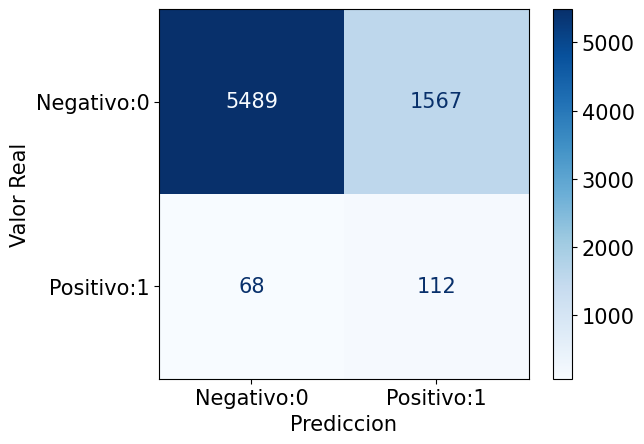

In [43]:
y_preds = model.predict(X_test)
print("Reporte de metricas XGBoost: \n", classification_report(y_test, y_preds))
matriz = confusion_matrix(y_test, y_preds)
print('Matriz de Confusión:\n',matriz)


mc=confusion_matrix(y_test,y_preds)
cm_display =ConfusionMatrixDisplay(mc,display_labels=["Negativo:0", "Positivo:1"]).plot(cmap=plt.cm.Blues)
cm_display.ax_.set_xlabel("Prediccion")
cm_display.ax_.set_ylabel("Valor Real")

In [44]:
# los modelos a usar seran LR, xgb y lgb
# LR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga']
}

In [45]:
model_lr = LogisticRegression()
grid_search = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=5, scoring='accuracy')

In [46]:
# Ajustar el GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train_resampled, y_train_resampled)

c:\Users\jvald\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jvald\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jvald\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jvald\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jvald\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1.0, 10.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [48]:
# Obtener los mejores parámetros encontrados
best_params = grid_search.best_params_
print("Mejores parámetros:", best_params)

Mejores parámetros: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [49]:
model_LR = LogisticRegression(penalty='l1', C= 0.1 , solver= 'liblinear')

In [51]:
model_LR.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [52]:
print(model_LR.score(X_test, y_test))

0.695273631840796


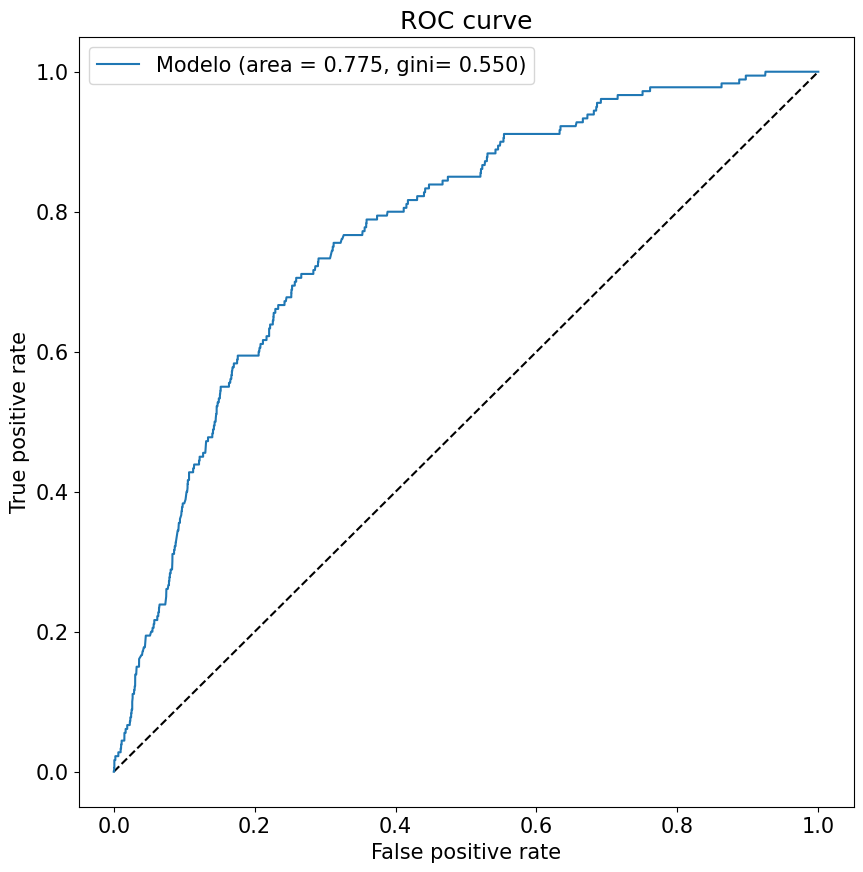

In [53]:
roc_auc=roc_gini(model_LR)

Reporte de metricas XGBoost: 
               precision    recall  f1-score   support

           0       0.99      0.69      0.82      7056
           1       0.06      0.73      0.11       180

    accuracy                           0.70      7236
   macro avg       0.52      0.71      0.46      7236
weighted avg       0.97      0.70      0.80      7236

Matriz de Confusión:
 [[4899 2157]
 [  48  132]]


Text(0, 0.5, 'Valor Real')

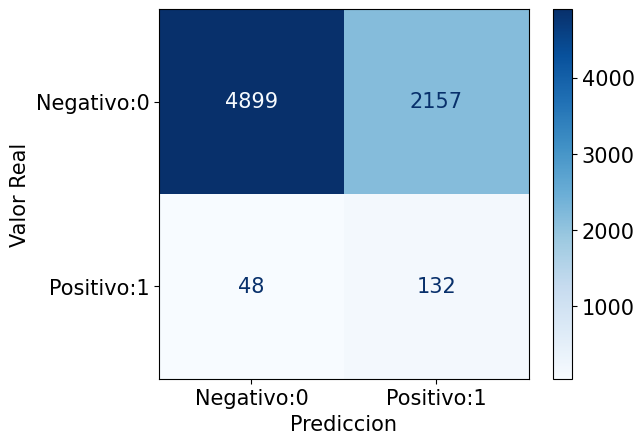

In [54]:
y_preds = model_LR.predict(X_test)
print("Reporte de metricas XGBoost: \n", classification_report(y_test, y_preds))
matriz = confusion_matrix(y_test, y_preds)
print('Matriz de Confusión:\n',matriz)


mc=confusion_matrix(y_test,y_preds)
cm_display =ConfusionMatrixDisplay(mc,display_labels=["Negativo:0", "Positivo:1"]).plot(cmap=plt.cm.Blues)
cm_display.ax_.set_xlabel("Prediccion")
cm_display.ax_.set_ylabel("Valor Real")

In [55]:
#xgb

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Definir los hiperparámetros a ajustar y sus posibles valores
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Crear un modelo XGBClassifier
model = XGBClassifier()

# Crear un objeto GridSearchCV y configurarlo con el modelo, los parámetros y la métrica de evaluación
grid_search = GridSearchCV(model, param_grid, scoring='accuracy')

In [56]:
# Ajustar el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [57]:
best_params = grid_search.best_params_

In [58]:
print("Mejores parámetros:", best_params)

Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


In [59]:
model_xgb = XGBClassifier(learning_rate = 0.1 , max_depth = 5, n_estimators = 300)

In [60]:
model_xgb.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [61]:
print(model_xgb.score(X_test, y_test))

0.7788833609729132


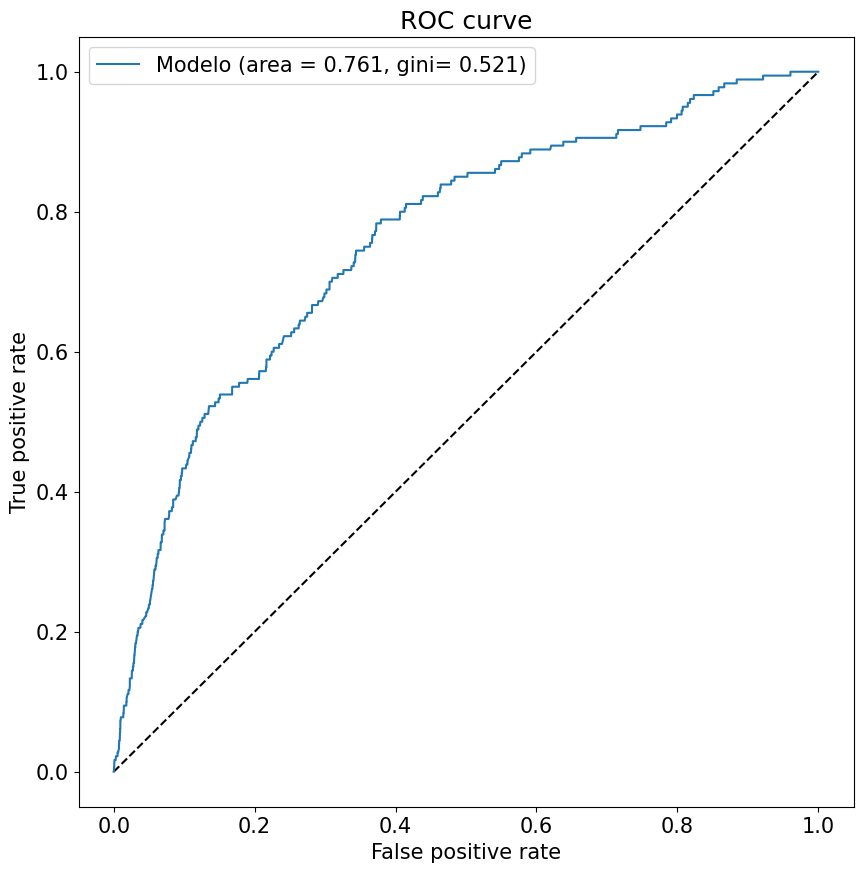

In [62]:
roc_auc=roc_gini(model_xgb)

Reporte de metricas XGBoost: 
               precision    recall  f1-score   support

           0       0.99      0.78      0.87      7056
           1       0.06      0.57      0.11       180

    accuracy                           0.78      7236
   macro avg       0.52      0.68      0.49      7236
weighted avg       0.96      0.78      0.85      7236

Matriz de Confusión:
 [[5533 1523]
 [  77  103]]


Text(0, 0.5, 'Valor Real')

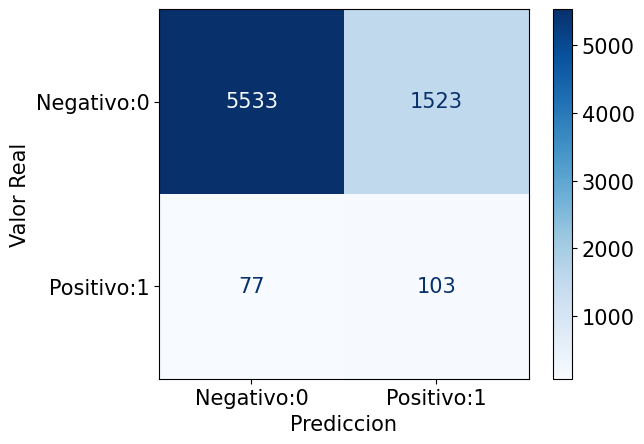

In [63]:
y_preds = model_xgb.predict(X_test)
print("Reporte de metricas XGBoost: \n", classification_report(y_test, y_preds))
matriz = confusion_matrix(y_test, y_preds)
print('Matriz de Confusión:\n',matriz)


mc=confusion_matrix(y_test,y_preds)
cm_display =ConfusionMatrixDisplay(mc,display_labels=["Negativo:0", "Positivo:1"]).plot(cmap=plt.cm.Blues)
cm_display.ax_.set_xlabel("Prediccion")
cm_display.ax_.set_ylabel("Valor Real")